In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np
import joblib
from sklearn.utils import class_weight
import keras
import os

2023-11-15 23:01:54,433 WARNING: From C:\Users\carl\PycharmProjects\ID2223_lab1\venv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine quality dataset",
                                  labels=["quality"],
                                  query=query)
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.1)

Finished: Reading data from Hopsworks, using ArrowFlight (1.05s) 


In [6]:
n_input = 7 # Number of features
n_hidden = 256  # Number of hidden nodes
n_out = 3 # Number of classes

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = keras.Sequential([
    keras.layers.Dense(n_hidden, input_dim=n_input, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, activation='selu'),
    keras.layers.Dense(n_out, activation='softmax')
])
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train['quality']),
                                                 y=y_train['quality'])
print(class_weights)
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00025), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, class_weight=dict(zip(np.unique(y_train['quality']), class_weights)), batch_size=256)

In [18]:
X_train

[0.89001502 0.76471537 1.75824991]
Epoch 1/150
10/10 [==============================] - 1s 19ms/step - loss: 1.0258 - accuracy: 0.4639 - val_loss: 1.4220 - val_accuracy: 0.3700
Epoch 2/150
10/10 [==============================] - 0s 7ms/step - loss: 0.9239 - accuracy: 0.5186 - val_loss: 1.3948 - val_accuracy: 0.3909
Epoch 3/150
10/10 [==============================] - 0s 7ms/step - loss: 0.9125 - accuracy: 0.5331 - val_loss: 1.3049 - val_accuracy: 0.3814
Epoch 4/150
10/10 [==============================] - 0s 7ms/step - loss: 0.9031 - accuracy: 0.5209 - val_loss: 1.3296 - val_accuracy: 0.3624
Epoch 5/150
10/10 [==============================] - 0s 7ms/step - loss: 0.8745 - accuracy: 0.5356 - val_loss: 1.3199 - val_accuracy: 0.3681
Epoch 6/150
10/10 [==============================] - 0s 7ms/step - loss: 0.8808 - accuracy: 0.5236 - val_loss: 1.2716 - val_accuracy: 0.3757
Epoch 7/150
10/10 [==============================] - 0s 7ms/step - loss: 0.8707 - accuracy: 0.5456 - val_loss: 1.3185 

In [19]:
y_train

,type,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol
0,0,0.28,0.14,0.032,142.0,0.99542,9.500000
1,0,0.25,0.41,0.042,173.0,0.99650,9.100000
2,0,0.33,0.27,0.036,134.0,0.99270,10.400000
4,0,0.28,0.31,0.046,208.0,0.99434,9.800000
5,0,0.51,0.25,0.048,177.0,0.99212,10.566667
...,...,...,...,...,...,...,...
5264,0,0.20,0.26,0.046,143.0,0.99526,10.800000
5265,0,0.28,0.36,0.038,101.0,0.99120,11.600000
5266,0,0.18,0.31,0.058,167.0,0.99310,10.000000
5267,0,0.35,0.25,0.051,182.0,0.99946,9.300000


In [20]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

,quality
0,1
1,0
2,2
4,0
5,0
...,...
5264,1
5265,1
5266,2
5267,1


In [21]:
print(metrics)

17/17 [==============================] - 0s 906us/step


In [22]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Low Quality', 'True Good Quality', 'True High Quality'],
                     ['Pred Low Quality', 'Pred Good Quality', 'Pred High Quality'])
cm = sns.heatmap(df_cm, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = cm.get_figure()

{'0': {'precision': 0.6273584905660378, 'recall': 0.689119170984456, 'f1-score': 0.6567901234567901, 'support': 193.0}, '1': {'precision': 0.5404040404040404, 'recall': 0.46120689655172414, 'f1-score': 0.4976744186046511, 'support': 232.0}, '2': {'precision': 0.5042735042735043, 'recall': 0.5784313725490197, 'f1-score': 0.5388127853881278, 'support': 102.0}, 'accuracy': 0.5673624288425048, 'macro avg': {'precision': 0.5573453450811942, 'recall': 0.5762524800283999, 'f1-score': 0.564425775816523, 'support': 527.0}, 'weighted avg': {'precision': 0.5652558320472109, 'recall': 0.5673624288425048, 'f1-score': 0.5639086585446462, 'support': 527.0}}


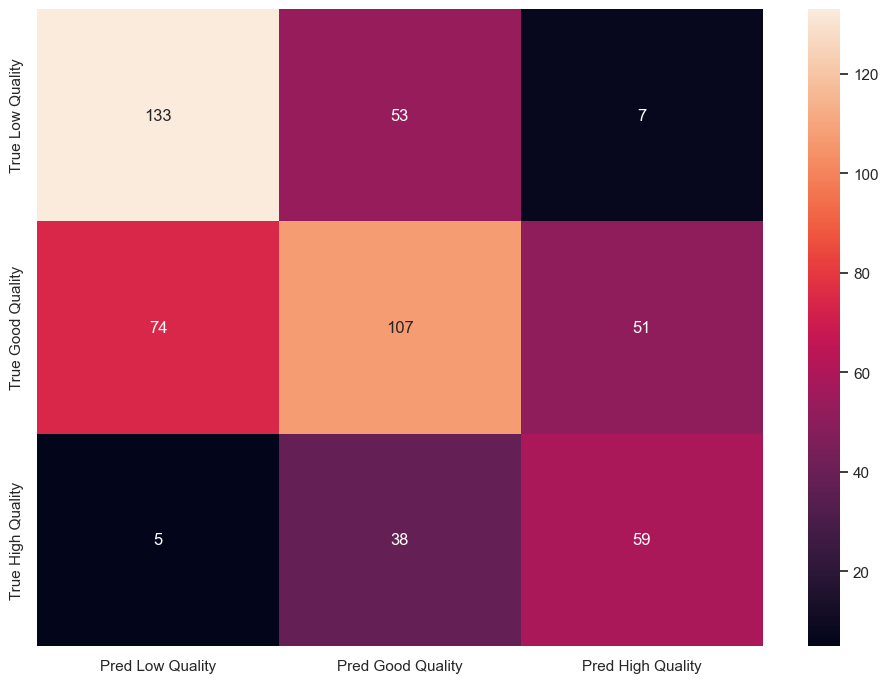

In [23]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
model.save_weights(model_dir + '/wine_model.h5')
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/191638/models/wine_model/1


Model(name: 'wine_model', version: 1)